# Analysing river flow data


## Step 1: Data Collection

### Tasks: 
- Choosing a reliable source for historical river flow data: [National River Flow Archive](https://nrfa.ceh.ac.uk)

- Choosing a gauging station: [Bathford station (53018)](https://nrfa.ceh.ac.uk/data/station/info/53018) on the River Avon, my local river

- Downloading the data for Bathford station. This consists of 2 CSV files: *Gauged Daily Flow Data (GDF)* and *Catchment Daily Rainfall Data (CDR)* 

- Creating a new folder for my project in my IDE editor, VS Code, and saving the CSV files in that folder. Creating a new jupyter notebook file for my project in same folder

- Creating a new virtual environment for my project, which includes pip installing the necessary library packages: more info on those steps in the project wiki

- Importing the necessary libraries

- Loading the data from both CSV files into a single combined DataFrame

- More info on the CSV files: the first 20 rows are metadata rows that need to be removed; there is no clear header row with column names (this confused me a lot!); 53018_gdf.csv (river flow) covers the period from 1969-10-27 to 2022-09-30, whereas 53018_cdr.csv (rainfall) covers the period from 1961-01-01 to 2017-12-31 so the time periods are mismatched; 53018_gdf.csv (river flow) has two columns, whereas 53018_cdr.csv (rainfall) has a third column with the value of the distance to the closest rain gauge used to interpolate rainfall at that grid point - in the case of Bathford station that value was 3000m for every observation.

In [73]:
#Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Loading CSV files into two separate DataFrames.
# Removing metadata rows; removing mismatched rows and columns; parsing dates; setting index column

# Calculate the number of rows to read in 53018_gdf.csv to match the shorter end period in 53018_cdr.csv.
rows_to_read = 17616 - 20 + 1

# Read the csv files, skipping extra initial rows in 53018_cdr.csv to match the later start period in 53018_gdf.csv.
df_rain = pd.read_csv('53018_cdr.csv',skiprows=3241, parse_dates=['1969-10-27'], index_col='1969-10-27')
df_flow = pd.read_csv('53018_gdf.csv',skiprows=20, nrows=rows_to_read, parse_dates=['1969-10-27'], index_col='1969-10-27')

#Selecting desired columns from each DataFrame
columns_from_df_rain = df_rain[['0.000']]
columns_from_df_flow = df_flow[['3.998']]

#Merging the two DataFrames into a single DataFrame
combined_df = pd.concat([columns_from_df_rain, columns_from_df_flow], axis=1)

# Renaming csv column names to Rainfall and Flow
combined_df = combined_df.rename(columns={
    '0.000': 'Rainfall',
    '3.998': 'Flow'
})

# Renaming the index column
combined_df.index.name = 'Date'

# Display head and tail of the combined DataFrame to check columns start and end at same date
print(combined_df.head( ))
print(combined_df.tail(5))

# Check the shape of the combined DataFrame and save the total number of rows
print(combined_df.shape)
total_rows = combined_df.shape[0]

            Rainfall   Flow
Date                       
1969-10-28       0.0  3.958
1969-10-29       0.0  4.210
1969-10-30       0.0  4.480
1969-10-31       0.0  4.205
1969-11-01       0.1  3.830
            Rainfall   Flow
Date                       
2017-12-27       0.2  98.23
2017-12-28       4.3  78.77
2017-12-29       4.4  49.72
2017-12-30       5.8  53.17
2017-12-31       3.5  52.10
(17597, 2)


## Step 2: Cleaning the Data

### Tasks:

- Check for data consistency

- Check for missing values

- Check for duplicates

- Check for outliers

In [74]:
#Checking for consistency in data format
print(combined_df.dtypes) #both columns are float64 

# Checking for missing values 
print(combined_df.isnull().sum()) #no missing values 

# Checking for duplicates in Date column    
print(combined_df.index.duplicated().sum()) #no duplicates

Rainfall    float64
Flow        float64
dtype: object
Rainfall    0
Flow        0
dtype: int64
0


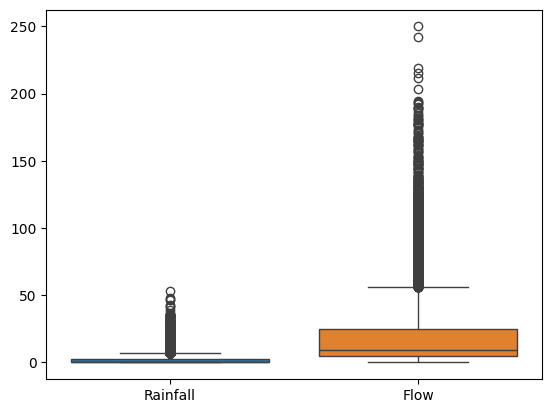

            Rainfall    Flow
Date                        
1969-11-06      13.2   4.004
1969-11-08       7.0   4.283
1969-11-09       9.4   5.806
1969-11-11      13.3   8.994
1969-11-14      13.7  12.010
...              ...     ...
2017-12-14       3.9  58.370
2017-12-25      15.4  21.630
2017-12-26      21.3  71.250
2017-12-27       0.2  98.230
2017-12-28       4.3  78.770

[2915 rows x 2 columns]
Percentage of outliers: 16.57%


In [75]:
#Checking for outliers
sns.boxplot(data=combined_df)
plt.show() 

#Identify outliers in the combined DataFrame using the IQR method
Q1 = combined_df.quantile(0.25)
Q3 = combined_df.quantile(0.75)
IQR = Q3 - Q1

# Define outliers
outliers = ((combined_df < (Q1 - 1.5 * IQR)) | (combined_df > (Q3 + 1.5 * IQR)))

# Display the rows with outliers 
print(combined_df[outliers.any(axis=1)])

# Calculate the number of rows with outliers
outlier_rows = outliers.any(axis=1).sum()

# Calculate the percentage of outliers
outlier_percentage = (outlier_rows / total_rows) * 100

print(f"Percentage of outliers: {outlier_percentage:.2f}%")

The percentage of outliers is 16.57%. 

This is a significant percentage of the dataset, but in the context of hydrological data it is not uncommon to have outliers due to severe weather. Since they are an essential part to understanding the risks and impacts of extreme weather events, we will keep the outliers in the dataset.


## Step 3: Exploratory Data Analysis

### Tasks:

- Calculate Summary Statistics

- Explore the Shape of Distribution

- Investigate Relationships and Correlation.

- Identify Seasonal Patterns/Trends over Time


In [76]:
#Calculating Summary Statistics
summary_statistics = combined_df.describe()
print(summary_statistics)


           Rainfall          Flow
count  17597.000000  17597.000000
mean       2.319708     19.773551
std        4.306125     24.778688
min        0.000000      0.122000
25%        0.000000      4.725000
50%        0.300000      9.534000
75%        2.800000     25.160000
max       53.200000    249.900000


**Rainfall and river flow summary statistics:**

The majority of rainfall observations are low, with a median of 0.30 mm and 75% of observations below 2.80 mm.
There are some extreme values, with a maximum of 53.20 mm.


The flow data has a median of 9.53 m³/s and 75% of observations below 25.16 m³/s.
There are significant outliers, with a maximum flow of 249.90 m³/s.
The high standard deviation (24.78 m³/s) indicates considerable variability in river flow.

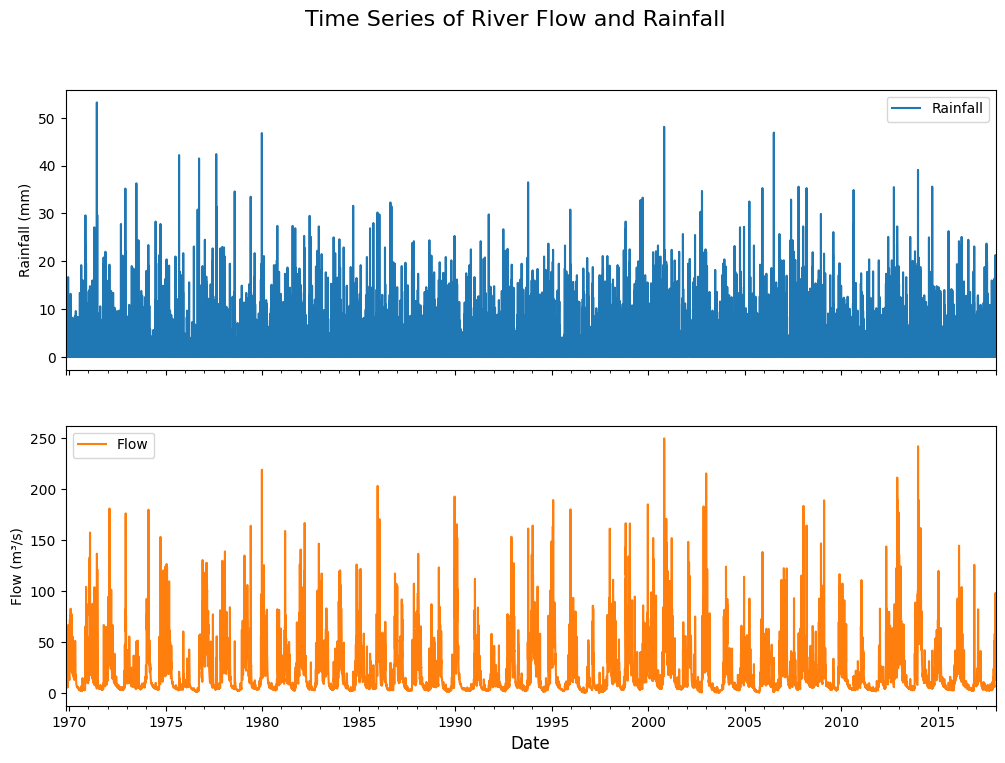

In [77]:
#Plot time series of river flow and rainfall with subplots
axes= combined_df.plot(subplots=True, figsize=(12, 8))

#Set main title
plt.suptitle('Time Series of River Flow and Rainfall', fontsize=16)

#Set x-axis label for all subplots
for ax in axes:
    ax.set_xlabel('Date', fontsize=12)

#Set y-axis label for each subplot
axes[0].set_ylabel('Rainfall (mm)')
axes[1].set_ylabel('Flow (m³/s)')

#Display the plot
plt.show()

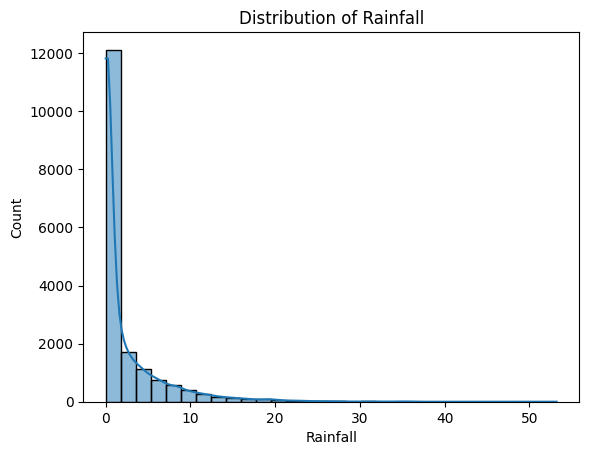

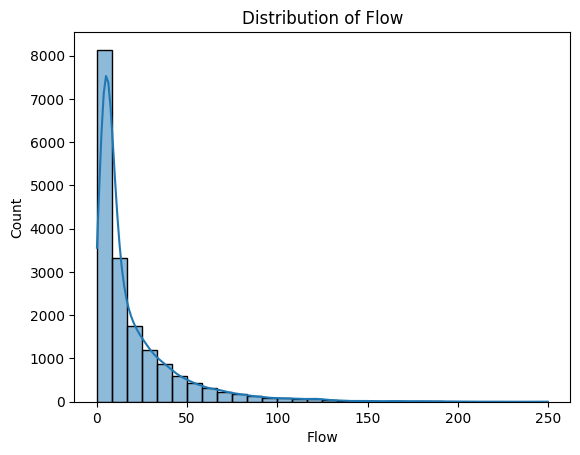

In [78]:
#Plotting the distribution of river flow and rainfall
sns.histplot(data=combined_df, x='Rainfall', bins=30, kde=True)
plt.title('Distribution of Rainfall')
plt.show()

sns.histplot(data=combined_df, x='Flow', bins=30, kde=True)
plt.title('Distribution of Flow')
plt.show()


**Distribution of river flow and rainfall:**

The distribution of rainfall is right-skewed, with most values concentrated around lower rainfall levels. 

The distribution of flow is also right-skewed, with most values concentrated around lower flow levels. 

Both variables have a wide range of values, indicating variability in the data.


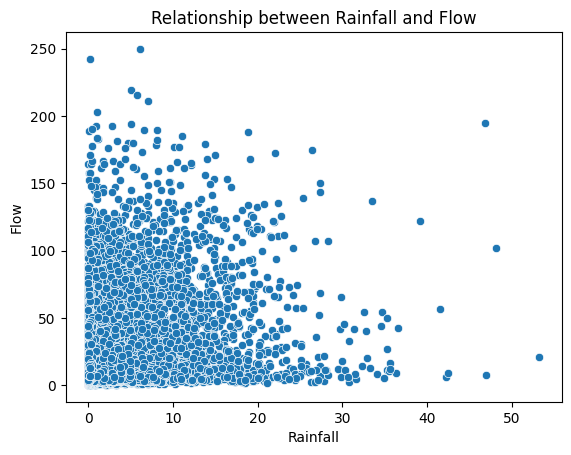

Correlation between Rainfall and Flow: 0.27


In [79]:
#Plotting the relationship between river flow and rainfall
sns.scatterplot(data=combined_df, x='Rainfall', y='Flow')
plt.title('Relationship between Rainfall and Flow')
plt.show()

#Calculating the correlation between river flow and rainfall
correlation = combined_df['Rainfall'].corr(combined_df['Flow'])
print(f"Correlation between Rainfall and Flow: {correlation:.2f}")


**Relationship between river flow and rainfall:**

The scatter plot shows a weak relationship between the two variables, the relationship is not linear, and there is considerable variability in the data.

The correlation between rainfall and flow is 0.27, indicating a weak positive correlation between the two variables.



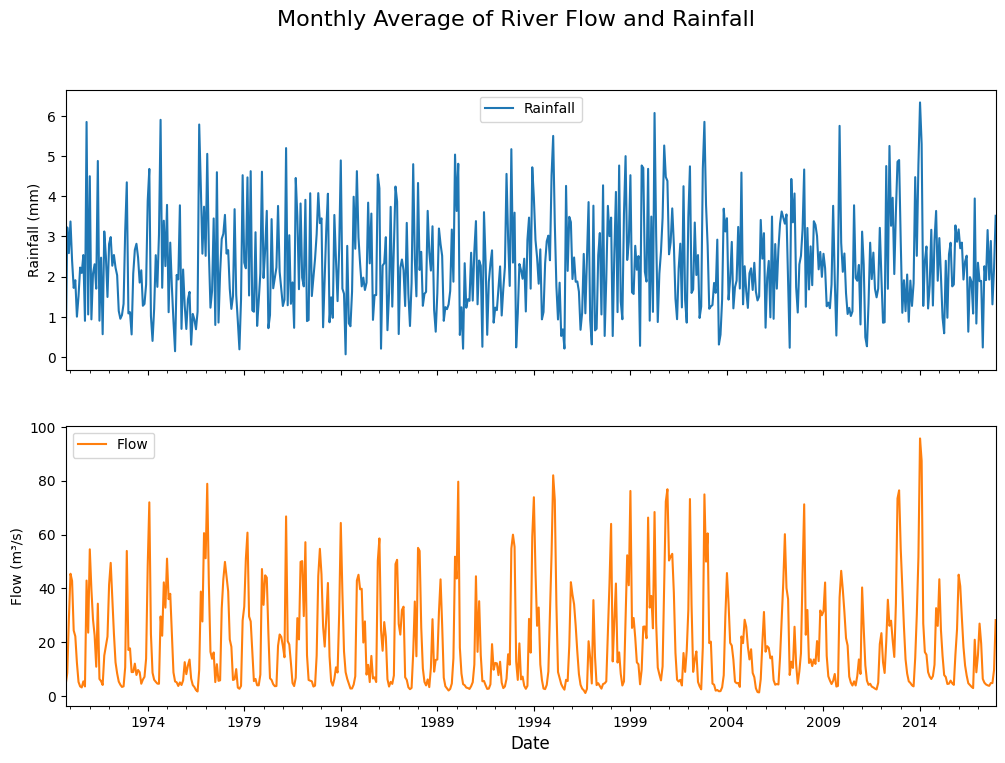

In [80]:
#- Identifying Seasonal Patterns/Trends over Time

# Calculate the monthly average of rainfall and flow
monthly_avg = combined_df.resample('ME').mean()  

# Plot the monthly average of rainfall and flow with subplots
# Plot with subplots
axes = monthly_avg.plot(subplots=True, figsize=(12, 8))

# Set the main title
plt.suptitle('Monthly Average of River Flow and Rainfall', fontsize=16)

# Set the x-axis label for all subplots
for ax in axes:
    ax.set_xlabel('Date', fontsize=12)
    
# Set the y-axis label for each subplot
axes[0].set_ylabel('Rainfall (mm)')
axes[1].set_ylabel('Flow (m³/s)')

# Display the plot
plt.show()


**Seasonal patterns in river flow and rainfall over time:**

There is a clear seasonal pattern in both variables, with higher values during certain months of the year. 

The relationship between rainfall and flow is evident in the plots, with flow increasing following periods of higher rainfall.


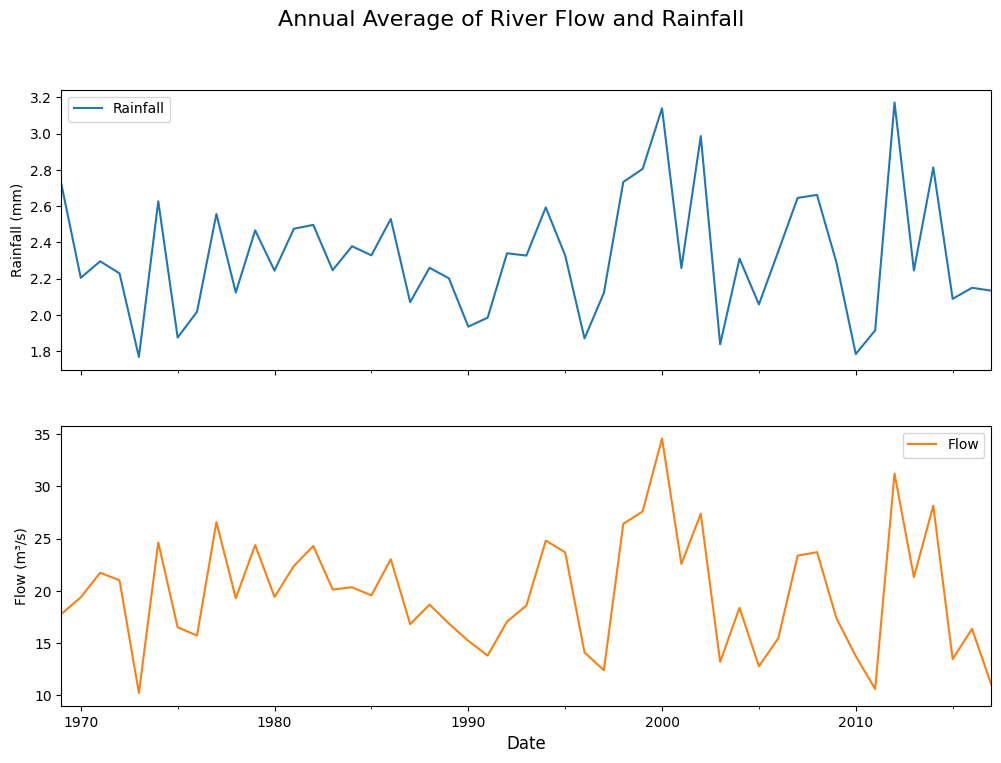

In [81]:
#Trend Analysis
# Calculate the annual average of rainfall and flow
annual_avg = combined_df.resample('YE').mean()

# Plot the annual average of rainfall and flow with subplots
# Plot with subplots
axes = annual_avg.plot(subplots=True, figsize=(12, 8))

# Set the main title
plt.suptitle('Annual Average of River Flow and Rainfall', fontsize=16)

# Set the x-axis label for all subplots
for ax in axes:
    ax.set_xlabel('Date', fontsize=12)

# Set the y-axis labels for each subplot
axes[0].set_ylabel('Rainfall (mm)')
axes[1].set_ylabel('Flow (m³/s)')

# Show the plot
plt.show()

**Trend analysis in river flow and rainfall over time**

The relationship between rainfall and flow is evident in the plots, with flow increasing following periods of higher rainfall.

The trend analysis shows rainfall and flow levels fluctuating widely from year to year, with no clear overall increasing trend. 

## Step 4: Concluding Report

In this project, I performed an exploratory data analysis on a dataset containing daily rainfall and river flow observations at Bathford gauging station on the River Avon. 

Both rainfall and river flow had highly right-skewed distributions with long tails due to the high number of outliers and both showed a high degree of variability as is to be expected in hydrological observations that are affected by weather events.

A surprising result was the weak positive correlation at 0.27 between rainfall and river flow.

This may have been due to that fact that at Bathford gauging station there is a railway bridge that acts as a control on the river flow.

Also, the rainfall data for the station's location is an interpolation from a rainfall gauge 3000m away. So it could be that this introduces a high degree of uncertainty associated with the data.

There was a clear seasonal pattern in river flow and rainfall over time but no clear evidence of an increasing trend over the years.

It's a shame that my rainfall data did not continue beyond 2017, as it would have been interesting to see whether with more recent observations there were signs of an increasing trend in rainfall as is now commonly expected to follow in the UK with a warming climate. 

Upon reflection, though I was motivated to choose Bathford station because it's local and meaningful to me, it would have been better to have spent longer researching my choice so as not to be limited by my data in the relationships I wished to explore.

## Step 5: Future goals

### Tasks:

- Use linear regressions to build and evaluate a predictive model

- Improve visualizations and explore interactive features through plotly

- Use APIs to update project dataset with most recent observations - this might require choosing a new observation station for my project.